# <center> CSML1020 - Project </center>
# <center> Pneumonia Detection - Xray Classification </center>

# Table of Contents

* [1. Loading the Data](#1)
* [2. Modelling](#2)

# 1. Loading the Data<a class="anchor" id="1"></a>

In [5]:
import pandas as pd
import numpy as np

# Load the training and testing data from the Google Cloud Storage Bucket
bucket_dir = 'gs://csml1020_project_data'
train_file = bucket_dir + '/' + 'train_img_array.csv'
test_file = bucket_dir + '/' + 'test_img_array.csv'

train = pd.read_csv(train_file) 
test = pd.read_csv(test_file) 

# shuffle the DataFrame rows 
train = train.sample(frac = 1) 
test = test.sample(frac = 1) 

In [6]:
# Check shape of the training and testing datasets
print("Train Shape: ", train.shape)
print("Test Shape: ", test.shape)

Train Shape:  (5216, 10002)
Test Shape:  (624, 10002)


In [7]:
# Drop the Image_Id column from both datasets as it will not be used for modelling
train = train.drop(columns=['Image_Id'])
test = test.drop(columns=['Image_Id'])

In [8]:
import tensorflow.keras as keras
num_categories = 2
# Split the features from the target variables in both the training and testing datasets

train_y = train['has_Pneumonia?']
train_x = train.drop(columns = ['has_Pneumonia?'])
#train_x = train_x.values
#train_y = keras.utils.to_categorical(train_y, num_categories)

test_y = test['has_Pneumonia?']
test_x = test.drop(columns = ['has_Pneumonia?'])
#test_x = test_x.values
#test_y = keras.utils.to_categorical(test_y, num_categories)

In [9]:
# Normalize the training and testing features
train_x = train_x/255
test_x  = test_x/255

In [10]:
# Converting the dataframe to arrays
train_x = train_x.to_numpy()
test_x = test_x.to_numpy()

train_y = train_y.to_numpy()
test_y = test_y.to_numpy()

In [11]:
# Check shape data
print("train_x shape: ",train_x.shape)
print("test_x shape: ",test_x.shape)

print("train_y shape: ",train_y.shape)
print("test_y shape: ",test_y.shape)

train_x shape:  (5216, 10000)
test_x shape:  (624, 10000)
train_y shape:  (5216,)
test_y shape:  (624,)


# 2. Modelling<a class="anchor" id="2"></a>

## 2.1 Baseline Neural Network

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_basic_NN_model():

    model = Sequential()
    # Adding the input layer to the model
    model.add(Dense(units=512, activation='relu', input_shape=(10000,)))
    # Adding a hidden layer
    model.add(Dense(units = 512, activation='relu'))
    # Adding the output layer
    model.add(Dense(units = 1, activation='sigmoid'))
    # Provide summary of the model
    model.summary()
    # Compile the model
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [13]:
%%time
# Training our model
NN_model = get_basic_NN_model()
NN_history = NN_model.fit(train_x, train_y, epochs=20, verbose=1, validation_data = (test_x, test_y))

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(NN_history.history) 
hist_df.to_csv('gs://csml1020_project_data/model/NN_model_history.csv',index=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               5120512   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
163/163 [==============================] - 6s 34ms/step - loss: 3.0176 - accuracy: 0.6695 - val_loss: 0.4994 - val_accuracy: 0.7420
Epoch 2/20
163/163 [==============================] - 5s 31ms/step - loss: 0.3623 - accuracy: 0.8536 - val_loss: 0.3851 - val_accuracy: 0.8462
Epoch 3/20
163/163 [==============================] - 5s 32ms/step - loss: 0.2787 - accura

* Observing the numbers above we can see that our model is overfitting the data. 

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,auc

# Define a function to display the accuracy vs epoch and loss vs epochs
def display_loss_accuracy(model_fit_history):
    train_loss = model_fit_history.history['loss']
    train_acc = model_fit_history.history['accuracy']
    test_loss = model_fit_history.history['val_loss']
    test_acc = model_fit_history.history['val_accuracy']
    epochs = [i for i in range(1, len(test_acc)+1)]

    fig, ax = plt.subplots(1,2, figsize = (15,5))
    ax[0].plot(epochs, train_loss, label = 'Train Loss')
    ax[0].plot(epochs, test_loss, label = 'Test Loss')
    ax[0].set_title('Train/Test Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, train_acc, label = 'Train Accuracy')
    ax[1].plot(epochs, test_acc, label = 'Test Accuracy')
    ax[1].set_title('Train/Test Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

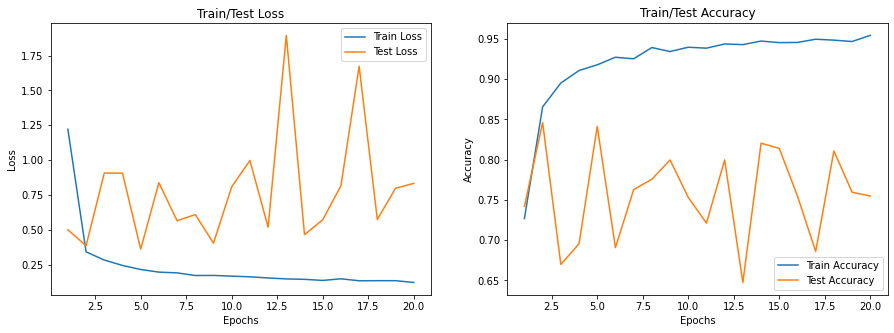

In [15]:
# Display the loss vs epochs and accuracy vs epochs graphs
display_loss_accuracy(NN_history)
# Use the NN model to make predictions
#y_test_pred = NN_model.predict(test_x)


## 2.2 Baseline Convolutional Neural Network

In [16]:
# First we need to reshape the training and testing datasets for CNN
train_x = train_x.reshape(-1,100,100,1)
test_x = test_x.reshape(-1,100,100,1)

In [17]:
# Check the shape
train_x.shape,test_x.shape

((5216, 100, 100, 1), (624, 100, 100, 1))

In [18]:
# Increase the dataset using data augmentation

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(train_x)

In [19]:
# Source: NVIDIA fundamentals of deep learning course
# Build the Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization)

def get_CNN_model():

    model = Sequential()
    model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", input_shape=(100,100, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D((2, 2), strides=2, padding="same"))
    model.add(Flatten())
    model.add(Dense(units=512, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(units=1, activation="sigmoid"))

    # Provide summary of the model
    model.summary()
    # Compile the model
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Training our model
CNN_model = get_CNN_model()
CNN_history = CNN_model.fit(datagen.flow(train_x,train_y, batch_size = 32),
                    epochs=20, verbose=1, validation_data = (test_x, test_y))

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(CNN_history.history) 
hist_df.to_csv('gs://csml1020_project_data/model/CNN_model_history.csv',index=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 75)      750       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 75)      300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 75)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 50)        33800     
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 50)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 50)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 50)       

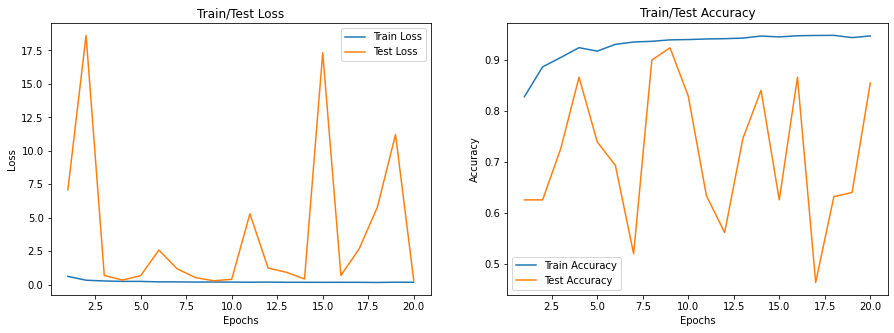

In [ ]:
# Display the loss vs epochs and accuracy vs epochs graphs
display_loss_accuracy(CNN_history)

In [ ]:
# Source: https://towardsdatascience.com/using-ai-to-detect-pneumonia-3ec4601acd07
from keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import (Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization)

def get_conv_model_normal():
    
    inp_shape = (100,100,1)
    act = 'relu'
    drop = .5 
    kernal_reg = regularizers.l1(.001)
    dil_rate = 2
    
    model = Sequential() 
    
    model.add(Conv2D(64, kernel_size=(3,3),activation=act, input_shape = inp_shape, 
                     kernel_regularizer = kernal_reg,
                     kernel_initializer = 'he_uniform',  padding = 'same', name = 'Input_Layer'))
    model.add(Dense(64, activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),  strides = (2,2)))
    
    model.add(Conv2D(64, (3, 3), activation=act, kernel_regularizer = kernal_reg, dilation_rate = dil_rate, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Dense(64, activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))
    
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, dilation_rate = dil_rate, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(Conv2D(128, (3, 3), activation=act, kernel_regularizer = kernal_reg, dilation_rate = dil_rate, 
                     kernel_initializer = 'he_uniform',padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides = (2,2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dropout(drop))

    model.add(Dense(1, activation='sigmoid', name = 'Output_Layer'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model 

In [ ]:
# Display the loss vs epochs and accuracy vs epochs graphs
CNN_model_2 = get_conv_model_normal()
CNN_2_history = CNN_model_2.fit(datagen.flow(train_x,train_y, batch_size = 32),
                    epochs=50, verbose=1, validation_data = (test_x, test_y))


Epoch 1/50
163/163 [==============================] - 158s 965ms/step - loss: 6.7494 - accuracy: 0.7430 - val_loss: 1.3201 - val_accuracy: 0.6250
Epoch 2/50
163/163 [==============================] - 156s 955ms/step - loss: 1.0808 - accuracy: 0.7409 - val_loss: 0.9003 - val_accuracy: 0.6250
Epoch 3/50
163/163 [==============================] - 156s 956ms/step - loss: 0.7516 - accuracy: 0.7571 - val_loss: 0.7064 - val_accuracy: 0.7003
Epoch 4/50
163/163 [==============================] - 155s 949ms/step - loss: 0.5808 - accuracy: 0.8166 - val_loss: 0.6447 - val_accuracy: 0.7772
Epoch 5/50
163/163 [==============================] - 155s 950ms/step - loss: 0.5212 - accuracy: 0.8357 - val_loss: 0.6051 - val_accuracy: 0.7965
Epoch 6/50
163/163 [==============================] - 157s 966ms/step - loss: 0.4823 - accuracy: 0.8546 - val_loss: 0.5319 - val_accuracy: 0.8285
Epoch 7/50
163/163 [==============================] - 154s 947ms/step - loss: 0.4419 - accuracy: 0.8790 - val_loss: 0.5334 -

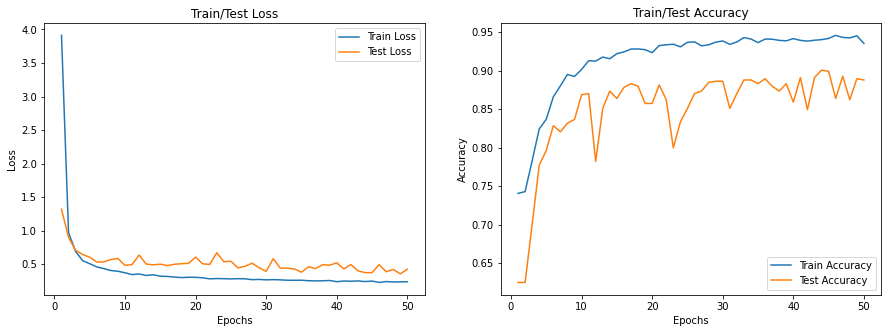

In [ ]:
# Display the results
display_loss_accuracy(CNN_2_history)


In [ ]:
from keras.models import save_model
# Save the model
#save_model(CNN_model_2,'gs://csml1020_project_data/model/')

In [ ]:
# Save the history

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(CNN_2_history.history) 
hist_df.to_csv('gs://csml1020_project_data/model/model_history.csv',index=False)

# or save to csv: 
#hist_csv_file = 'history.csv'
#with open(hist_csv_file, mode='w') as f:
#    hist_df.to_csv(f)

In [31]:
# Source: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

def CNN_model_3():
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(100,100,1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [32]:
# Display the loss vs epochs and accuracy vs epochs graphs
CNN_model_3 = CNN_model_3()
CNN_3_history = CNN_model_3.fit(datagen.flow(train_x,train_y, batch_size = 32),
                    epochs=20, verbose=1, validation_data = (test_x, test_y))

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(CNN_3_history.history) 
hist_df.to_csv('gs://csml1020_project_data/model/CNN_3_model_history.csv',index=False)


Epoch 1/20
163/163 [==============================] - 35s 209ms/step - loss: 0.6116 - accuracy: 0.7209 - val_loss: 0.6378 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 34s 209ms/step - loss: 0.4847 - accuracy: 0.7495 - val_loss: 0.4867 - val_accuracy: 0.7212
Epoch 3/20
163/163 [==============================] - 34s 209ms/step - loss: 0.3795 - accuracy: 0.7934 - val_loss: 0.3812 - val_accuracy: 0.8413
Epoch 4/20
163/163 [==============================] - 33s 205ms/step - loss: 0.3358 - accuracy: 0.8235 - val_loss: 0.3960 - val_accuracy: 0.8333
Epoch 5/20
163/163 [==============================] - 34s 207ms/step - loss: 0.3160 - accuracy: 0.8623 - val_loss: 0.3755 - val_accuracy: 0.8686
Epoch 6/20
163/163 [==============================] - 33s 204ms/step - loss: 0.2927 - accuracy: 0.8762 - val_loss: 0.3462 - val_accuracy: 0.8718
Epoch 7/20
163/163 [==============================] - 33s 200ms/step - loss: 0.2842 - accuracy: 0.8906 - val_loss: 0.3404 - val_ac

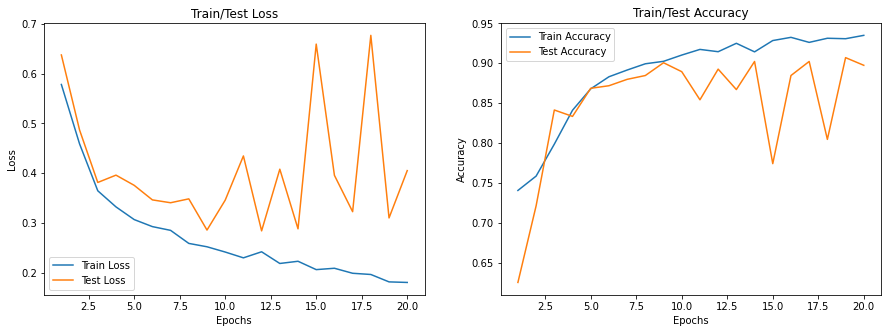

In [33]:
display_loss_accuracy(CNN_3_history)

In [ ]:
# rmsprop